In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl
from scipy.spatial import ConvexHull
import os
# our functions
import predict_Beta_I
import choice_start_day
import plot_hyb

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

## funcs

In [2]:
def create_boxplots(seed_dirs, type_start_day='roll_var_npeople', 
                    n_seeds=301, is_filename=False, suf=''):
    methods = [['$\mathregular{M_{last\_val}}$','$\mathregular{M_{ma\_val}}$',
        '$\mathregular{M_{ca\_val}}$','$\mathregular{M_{biexp}}$'], 

        ['$\mathregular{M_{median}}$','$\mathregular{M_{regr}}$'],

        ['$\mathregular{M^{shift}_{median}}$','$\mathregular{M^{shift}_{regr}}$',
        '$\mathregular{M^{add}_{regr}}$','$\mathregular{M_{reg\_ext}}$',    
        '$\mathregular{M_{LSTM}}$'
        ]]
    new_labels = [['last_value','rolling_mean_last_value',
        'expanding_mean_last_value','biexponential_decay'], 

        ['median_beta','regression_day'],

        ['median_beta_shifted_forecast','regression_day_shifted_forecast',
        'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I'
        ]]
    
    switch = type_start_day

    fig = plt.figure(figsize=(12, 4)) 
    gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.]) 
    
    if not is_filename:
        ntype, npop = seed_dirs[26:-1].split('_')
        if int(npop) == 10000:
            npop = ''
        elif int(npop) == 100000:
            npop = '_100k'
        elif int(npop) == 50000:
            npop = '_50k'
        
    ax_list = []    
    max_list = []
    for i in range(len(methods)):
        
        rmse_df = pd.DataFrame()
        for beta_prediction_method, new_label in zip(methods[i], new_labels[i]):
            try:
                # loading data from CSV
                if is_filename:
                    folder_name = seed_dirs.split('/')[1]
                    df = pd.read_csv(f'results/{folder_name}/{type_start_day}/{new_label}_results{suf}.csv')
                else:
                    df = pd.read_csv(f'results/{ntype+npop}/{type_start_day}/{new_label}_results{suf}.csv')
                # add data to DataFrame with the column name as the method
                rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
                print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
            
            except FileNotFoundError:
                rmse_df[f"{beta_prediction_method}"] = pd.DataFrame([0]*n_seeds)
                print(f'---- No data for {new_label} ----')
            
            
        max_list.append(rmse_df.max().max())
        # creating a boxplot
        ax = plt.subplot(gs[i])
        
        box = ax.boxplot(rmse_df[methods[i]], showfliers=True, 
                          medianprops=dict(color='red',linewidth=1.5), 
                          widths=0.5, patch_artist=True)
        median_c = (1.0, 0.7, 0.7, 0.2)
        lw=1
        for n, patch in enumerate(box['boxes']):
            if (i == 0) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 1) & (n < 1):
                patch.set(facecolor=median_c, linewidth=lw) 
            elif (i == 2) & (n < 3):
                patch.set(facecolor=median_c, linewidth=lw) 
            else:
                patch.set(fill=False)  
        
        ax.set_title(f'RMSE for Infected, group {i+1}')
        if i==1:
            ax.set_xlabel('Methods')
        if i==0:
            ax.set_ylabel('RMSE')
        ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
                labels=methods[i], rotation=0, ha='center', fontsize=13)
        ax.grid()  
        ax_list.append(ax)

    for ax in ax_list:
        ax.set_ylim(-50, np.max(max_list)*1.1
                   ) 
    if is_filename:
        plt.savefig(f'results/{folder_name}/{switch}/rmse_I_3{suf}.pdf', 
            format='pdf', bbox_inches='tight')
    else:
        plt.savefig(f'results/{ntype+npop}/{switch}/rmse_I_3{suf}.pdf', 
            format='pdf', bbox_inches='tight')

In [4]:
def create_peak_plot(folder = 'new_ba_10k', switch = 'roll_var_npeople',
                    with_outliers=True, same_lims=False, suf=''):
    fig, axes = plt.subplots(1,3, figsize=(11, 4))
    axes = axes.flatten()

    x_lim = (-130, 20)
    y_lim = (0.6, 2.3)
    size_m=120
    alpha_m=0.4
    alpha_area=0.35
    
    ax = axes[0]

    all_methods = [['$\mathregular{M_{last\_val}}$',
               '$\mathregular{M_{ca\_val}}$',
              '$\mathregular{M_{ma\_val}}$',
              '$\mathregular{M_{biexp}}$'],
               
               ['$\mathregular{M_{regr}}$',
               '$\mathregular{M_{median}}$'],
               
               ['$\mathregular{M^{shift}_{regr}}$',
               '$\mathregular{M^{shift}_{median}}$',
                '$\mathregular{M^{add}_{regr}}$',
                '$\mathregular{M_{LSTM}}$',
                '$\mathregular{M_{reg\_ext}}$']]
    
    all_new_labels = [['last_value','rolling_mean_last_value',
                  'expanding_mean_last_value',
                  'biexponential_decay'],
                  
                  ['regression_day', 'median_beta'],
                  
                  ['regression_day_shifted_forecast',
                  'median_beta_shifted_forecast',
                    'regression_day_incremental_learning',
                    'lstm_day_E_previous_I',
                    'regression_day_SEIR_previous_I']]
    
    
    ymin, ymax, xmin, xmax = 100, -100, 100, -100          
    for i, sub_methods, sub_labels in zip(np.arange(3), 
                                          all_methods, all_new_labels):
        plot_peaks_ax(axes[i], sub_methods, sub_labels, folder, switch,
                     x_lim, y_lim, size_m, alpha_m, alpha_area,
                     with_outliers, suf)
        if same_lims:
            ymin = np.min([ymin, axes[i].get_ylim()[0]])
            ymax = np.max([ymax, axes[i].get_ylim()[1]])
            xmin = np.min([xmin, axes[i].get_xlim()[0]])
            xmax = np.max([xmax, axes[i].get_xlim()[1]])
            
    if same_lims:     
        #pad = 0.2
        for i in np.arange(3):
            #if x_min < 0:
            #axes[i].set_xlim(xmin*(1-pad), xmax*(1+pad))
            #axes[i].set_ylim(ymin*(1-pad), ymax*(1+pad))
            axes[i].set_xlim(xmin, xmax)
            axes[i].set_ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(f'results/{folder}/{switch}/peaks_area.pdf', 
                format='pdf', bbox_inches='tight')

In [5]:
def find_outliers(vals):
    iqr = np.quantile(vals, .75) - np.quantile(vals, .25)
    l_out = np.quantile(vals, .25) - 1.5 * iqr
    h_out = np.quantile(vals, .75) + 1.5 * iqr
    
    if l_out != h_out:
        vals_idx = vals[(l_out<vals)&(vals<h_out)].index
    else:
        vals_idx = vals.index
        
    return vals_idx, l_out, h_out

In [6]:
def plot_peaks_ax(ax, methods, new_labels, folder, switch,
                 x_lim = (-130, 20), y_lim = (0.6, 2.3), size_m=120,
                  alpha_m=0.4, alpha_area=0.35, with_outliers=True, suf=''):
    ax.axvline(x=0, color='black', linestyle='--', 
               linewidth=1)
    ax.axhline(y=1, color='black', linestyle='--', 
               linewidth=1)
    
    cmap = mpl.colormaps['Set2']
    colors_l = cmap(np.linspace(0, 1, 8))
    colors = list(colors_l)[:len(methods)]
    
    for name, method in zip(new_labels, methods):
        try:
            p_df = pd.read_csv(f'results/{folder}/{switch}/{name}_results{suf}.csv')
            pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
            ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
            
            if not with_outliers:
                ph_idx, l_ph, h_ph = find_outliers(ph)
                pt_idx, l_pt, h_pt = find_outliers(pt)
                clean = list(set(ph_idx).intersection(pt_idx))
                ph = ph.loc[clean]
                pt = pt.loc[clean]

            hull = ConvexHull(pd.concat([pt,ph], axis=1))

            col = colors.pop()
            ax.scatter(pt,ph, marker='.', s=size_m,  alpha=alpha_m, 
                       label=method, zorder=10, color=col)

            ax.fill(pt.iloc[hull.vertices], 
                     ph.iloc[hull.vertices], alpha=alpha_area, color=col)
            
        except FileNotFoundError:
            pt = pd.Series([0]*301)
            ph = pd.Series([0]*301)
            print(f'---- No data for {name} ----')

    ax.grid()
    ax.set_xlabel('Peak time difference')
    #ax.set_xlim(x_lim)
    #ax.set_ylim(y_lim)

    leg = ax.legend(prop={'size': 13}, loc='best')
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    leg.set_zorder(20)

In [6]:
folder = 'new_ba_50000'
switch = 'roll_var_npeople'
with_outliers=False
same_lims=True
name = 'regression_day_SEIR_previous_I'

## boxplots

Median RMSE I for last_value 103.74392906140051
Median RMSE I for rolling_mean_last_value 234.9661294870812
Median RMSE I for expanding_mean_last_value 268.86024583865213
Median RMSE I for biexponential_decay 723.4990777085039
Median RMSE I for median_beta 43.03315635085184
Median RMSE I for regression_day 108.8656828816261
Median RMSE I for median_beta_shifted_forecast 180.16022818456779
Median RMSE I for regression_day_shifted_forecast 158.8057960174031
Median RMSE I for regression_day_incremental_learning 111.44555655268019
Median RMSE I for regression_day_SEIR_previous_I 39.99589192336497
Median RMSE I for lstm_day_E_previous_I 31.28515629456669


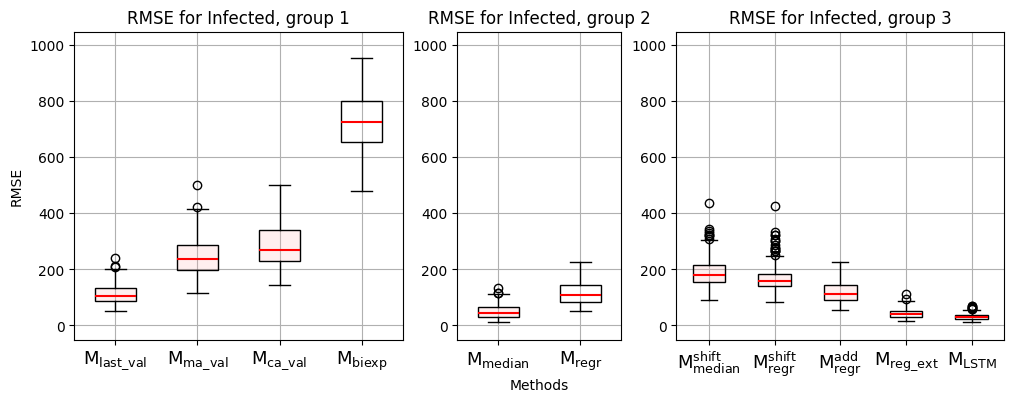

In [7]:
# 31 lstm
# 39 regression_day_SEIR_previous_I  
# 43 median_beta 
create_boxplots(seed_dirs='initial_data/new_ba_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 470.2344697506054
Median RMSE I for rolling_mean_last_value 1074.709387235419
Median RMSE I for expanding_mean_last_value 1270.2879148488178
Median RMSE I for biexponential_decay 3285.776938274344
Median RMSE I for median_beta 163.6755995003379
Median RMSE I for regression_day 502.33393457542024
Median RMSE I for median_beta_shifted_forecast 826.8724592446141
Median RMSE I for regression_day_shifted_forecast 779.143163625672
Median RMSE I for regression_day_incremental_learning 525.436280066812
Median RMSE I for regression_day_SEIR_previous_I 130.34642810441014
Median RMSE I for lstm_day_E_previous_I 96.01084409421755


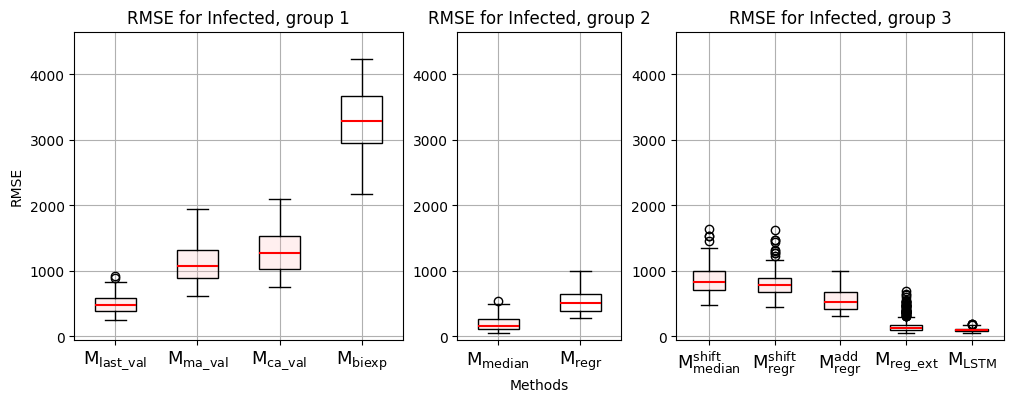

In [47]:
# 96 lstm
# 130 regression_day_SEIR_previous_I 
# 163 median_beta 
create_boxplots(seed_dirs='initial_data/new_ba_50000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 921.9743240041548
Median RMSE I for rolling_mean_last_value 2125.4667225151834
Median RMSE I for expanding_mean_last_value 2468.7213177472277
Median RMSE I for biexponential_decay 6454.065073760286
Median RMSE I for median_beta 303.9309215133657
Median RMSE I for regression_day 1021.5482630483157
Median RMSE I for median_beta_shifted_forecast 1624.606084501993
Median RMSE I for regression_day_shifted_forecast 1546.0542692735107
Median RMSE I for regression_day_incremental_learning 1092.4665403643303
Median RMSE I for regression_day_SEIR_previous_I 319.8585597291931
Median RMSE I for lstm_day_E_previous_I 181.19817249786118


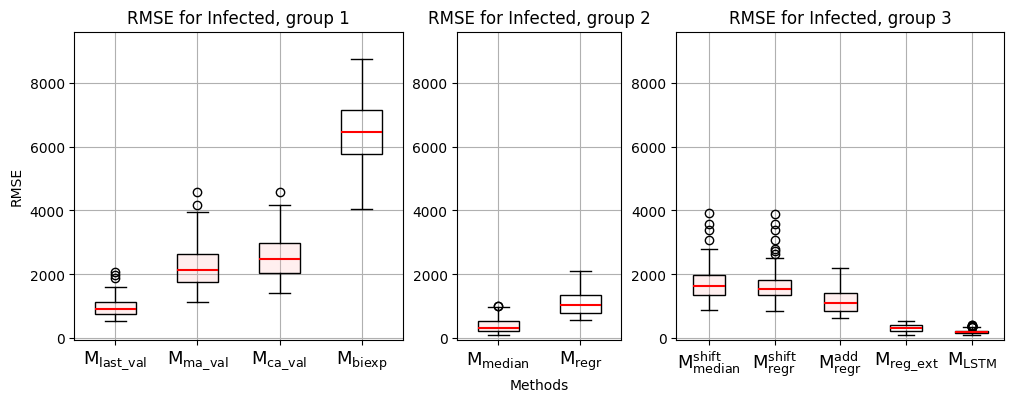

In [9]:
# 181 lstm
# 303 median_beta 
# 319 regression_day_SEIR_previous_I 
create_boxplots(seed_dirs='initial_data/new_ba_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 133.1191253005984
Median RMSE I for rolling_mean_last_value 114.0829069931946
Median RMSE I for expanding_mean_last_value 117.22600539642242
Median RMSE I for biexponential_decay 940.7410915226501
Median RMSE I for median_beta 167.24856707385243
Median RMSE I for regression_day 166.59269820971576
Median RMSE I for median_beta_shifted_forecast 105.39015872620449
Median RMSE I for regression_day_shifted_forecast 97.61260948778957
Median RMSE I for regression_day_incremental_learning 156.79787242050222
Median RMSE I for regression_day_SEIR_previous_I 124.06909292095614
Median RMSE I for lstm_day_E_previous_I 111.32027745276093


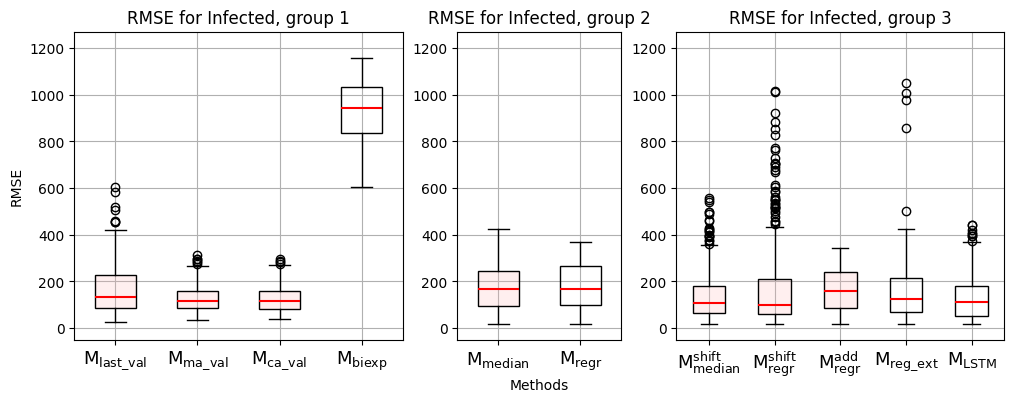

In [49]:
# 97 regression_day_shifted_forecast 
# 105 median_beta_shifted_forecast 
# 111 lstm_day_E_previous_I 
create_boxplots(seed_dirs='initial_data/new_r_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 520.4460614792849
Median RMSE I for rolling_mean_last_value 722.23097657121
Median RMSE I for expanding_mean_last_value 725.1993732511261
Median RMSE I for biexponential_decay 4552.038597392488
Median RMSE I for median_beta 852.9087448731461
Median RMSE I for regression_day 979.1248285227887
Median RMSE I for median_beta_shifted_forecast 498.9442179040591
Median RMSE I for regression_day_shifted_forecast 368.0642511423963
Median RMSE I for regression_day_incremental_learning 929.3563904952492
Median RMSE I for regression_day_SEIR_previous_I 660.2099620151739
Median RMSE I for lstm_day_E_previous_I 650.1257051035309


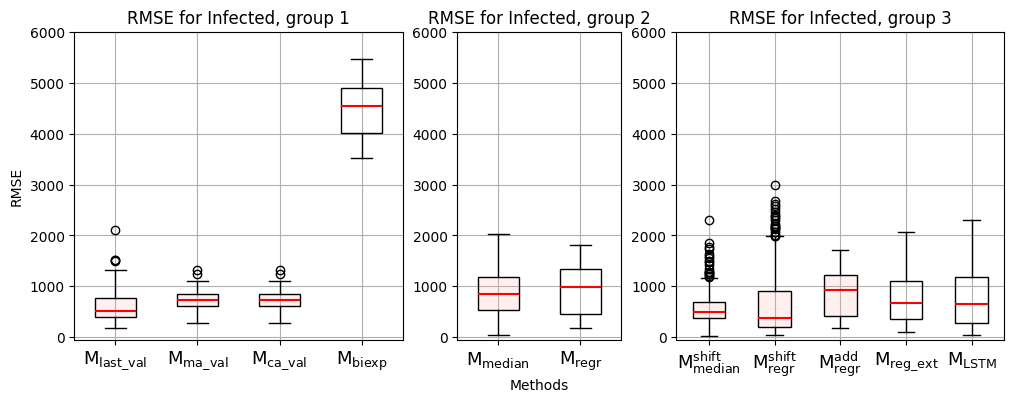

In [11]:
# 368 regression_day_shifted_forecast 
# 498 median_beta_shifted_forecast 
# 520 last_value  
create_boxplots(seed_dirs='initial_data/new_r_50000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 933.5698705843728
Median RMSE I for rolling_mean_last_value 1606.2435073024194
Median RMSE I for expanding_mean_last_value 1606.2435073024199
Median RMSE I for biexponential_decay 8848.444965237455
Median RMSE I for median_beta 1694.322806726429
Median RMSE I for regression_day 1519.38870319634
Median RMSE I for median_beta_shifted_forecast 1021.175696573943
Median RMSE I for regression_day_shifted_forecast 1065.02325258042
Median RMSE I for regression_day_incremental_learning 1393.5219254940043
Median RMSE I for regression_day_SEIR_previous_I 1169.1814996515109
Median RMSE I for lstm_day_E_previous_I 1241.8383938893453


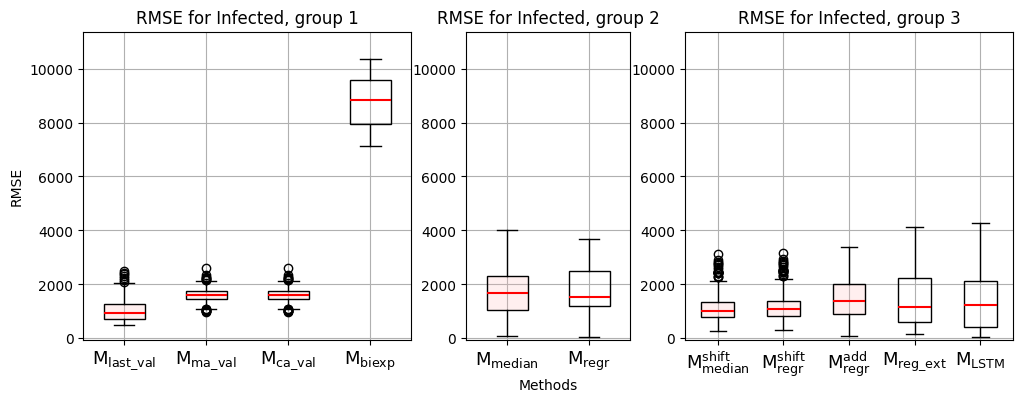

In [12]:
# 933 last_value 
# 1021 median_beta_shifted_forecast  
# 1065 regression_day_shifted_forecast   
create_boxplots(seed_dirs='initial_data/new_r_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 264.76900341602123
Median RMSE I for rolling_mean_last_value 164.37975836681093
Median RMSE I for expanding_mean_last_value 288.1889097866399
Median RMSE I for biexponential_decay 588.1703606870005
Median RMSE I for median_beta 236.9986031565751
Median RMSE I for regression_day 261.61236374678333
Median RMSE I for median_beta_shifted_forecast 162.81108853881258
Median RMSE I for regression_day_shifted_forecast 275.1606813534511
Median RMSE I for regression_day_incremental_learning 226.6874914810968
Median RMSE I for regression_day_SEIR_previous_I 115.04876165006928
Median RMSE I for lstm_day_E_previous_I 94.66633614226843


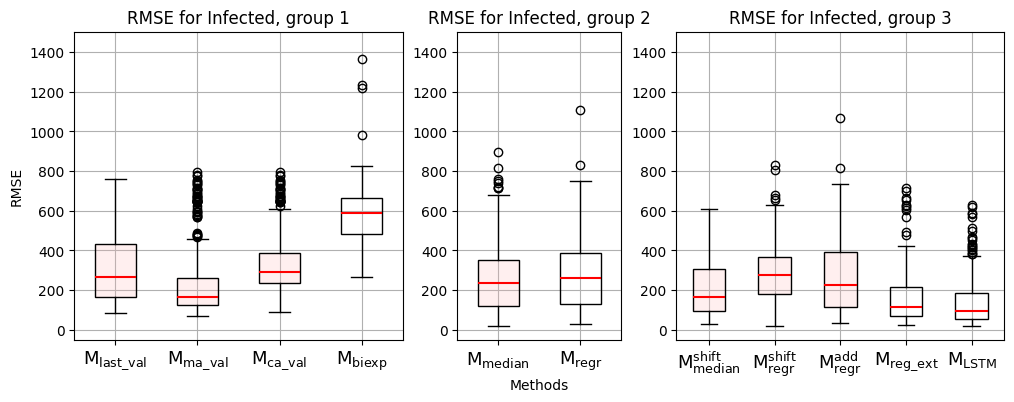

In [53]:
# 94 lstm 
# 115 regression_day_SEIR_previous_I   
# 162 median_beta_shifted_forecast 
# 164 rolling_mean_last_value 
create_boxplots(seed_dirs='initial_data/new_sw_10000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 3188.438478010301
Median RMSE I for rolling_mean_last_value 3331.250683886001
Median RMSE I for expanding_mean_last_value 3331.250683886001
Median RMSE I for biexponential_decay 3356.709983014588
Median RMSE I for median_beta 1496.8666993898178
Median RMSE I for regression_day 1571.1951916870664
Median RMSE I for median_beta_shifted_forecast 1205.4642346406886
Median RMSE I for regression_day_shifted_forecast 1771.3929382023787
Median RMSE I for regression_day_incremental_learning 1595.0335862230088
Median RMSE I for regression_day_SEIR_previous_I 1667.5061938874223
Median RMSE I for lstm_day_E_previous_I 1302.4273217997525


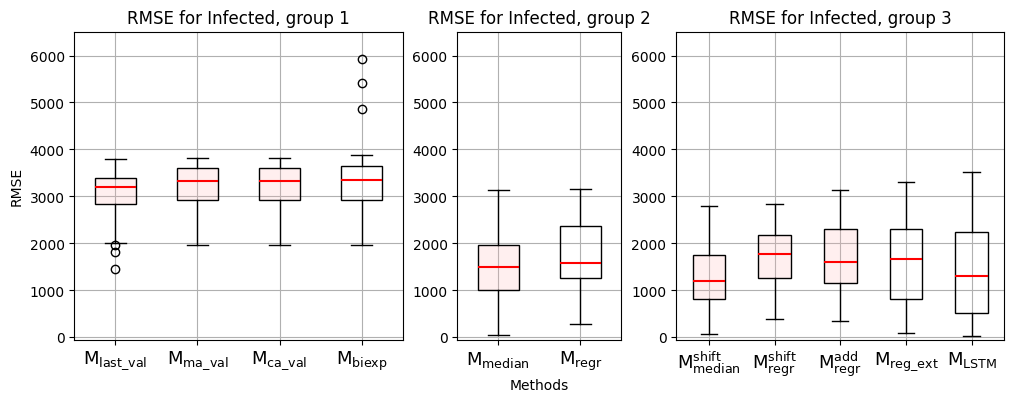

In [55]:
create_boxplots(seed_dirs='initial_data/new_sw_50000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 774.1324119192448
Median RMSE I for rolling_mean_last_value 642.2534110071813
Median RMSE I for expanding_mean_last_value 1557.3210123662643
Median RMSE I for biexponential_decay 2702.1579967909784
Median RMSE I for median_beta 1286.1964662178166
Median RMSE I for regression_day 1170.3545825220663
Median RMSE I for median_beta_shifted_forecast 641.3721815044404
Median RMSE I for regression_day_shifted_forecast 1153.3837020381427
Median RMSE I for regression_day_incremental_learning 892.541352839105
Median RMSE I for regression_day_SEIR_previous_I 537.0915127050046
---- No data for lstm_day_E_previous_I ----


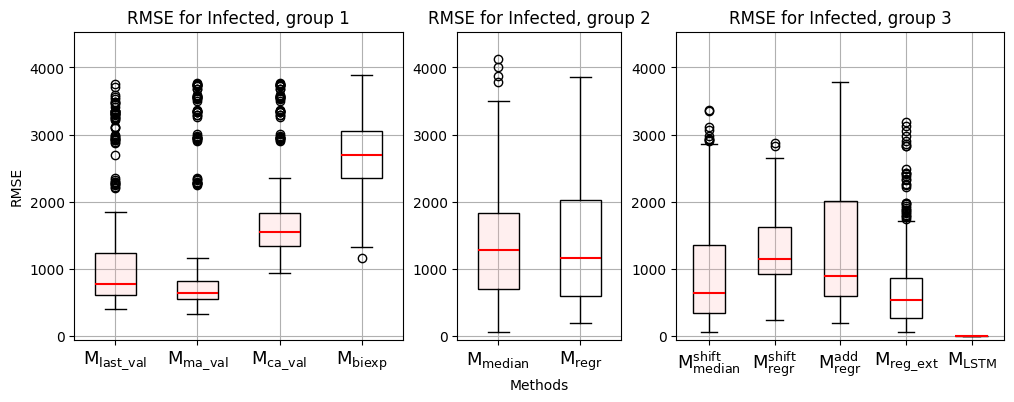

In [56]:
# 
# 537 regression_day_SEIR_previous_I   
# 641 median_beta_shifted_forecast 
# 642 rolling_mean_last_value 
create_boxplots(seed_dirs='initial_data/new_sw_50000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True, suf='_v2')

Median RMSE I for last_value 6515.791370725348
Median RMSE I for rolling_mean_last_value 6664.581753581942
Median RMSE I for expanding_mean_last_value 6664.581753581942
Median RMSE I for biexponential_decay 6691.1959067846765
Median RMSE I for median_beta 2980.2769350409226
Median RMSE I for regression_day 3031.4249781130075
Median RMSE I for median_beta_shifted_forecast 2620.9100829755434
Median RMSE I for regression_day_shifted_forecast 3805.161272474432
Median RMSE I for regression_day_incremental_learning 3116.0307741733704
Median RMSE I for regression_day_SEIR_previous_I 3100.997688854576
Median RMSE I for lstm_day_E_previous_I 2501.194296711405


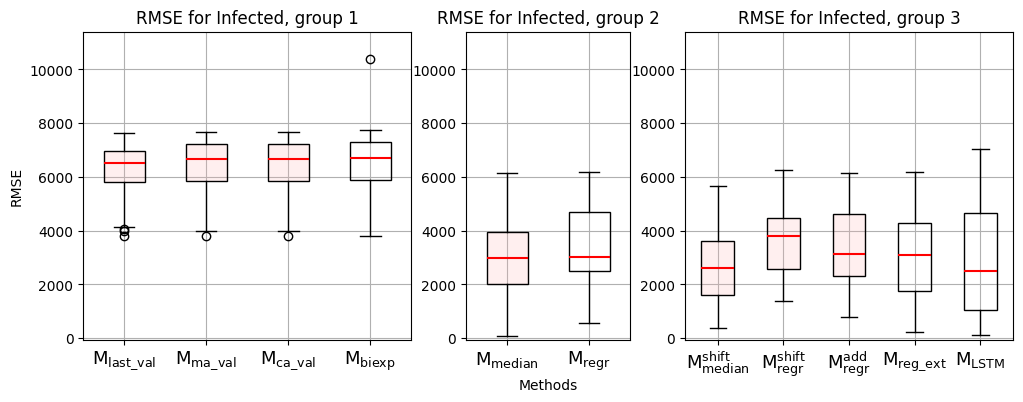

In [57]:
create_boxplots(seed_dirs='initial_data/new_sw_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True)

Median RMSE I for last_value 1480.3441052298572
Median RMSE I for rolling_mean_last_value 1257.847918803884
Median RMSE I for expanding_mean_last_value 3279.9000559572332
Median RMSE I for biexponential_decay 5563.4081741120735
Median RMSE I for median_beta 2665.5876745606065
Median RMSE I for regression_day 2391.4607364842796
Median RMSE I for median_beta_shifted_forecast 1142.3992920875535
Median RMSE I for regression_day_shifted_forecast 2133.1044232992112
Median RMSE I for regression_day_incremental_learning 1788.5227175662076
Median RMSE I for regression_day_SEIR_previous_I 1194.9129806761027
---- No data for lstm_day_E_previous_I ----


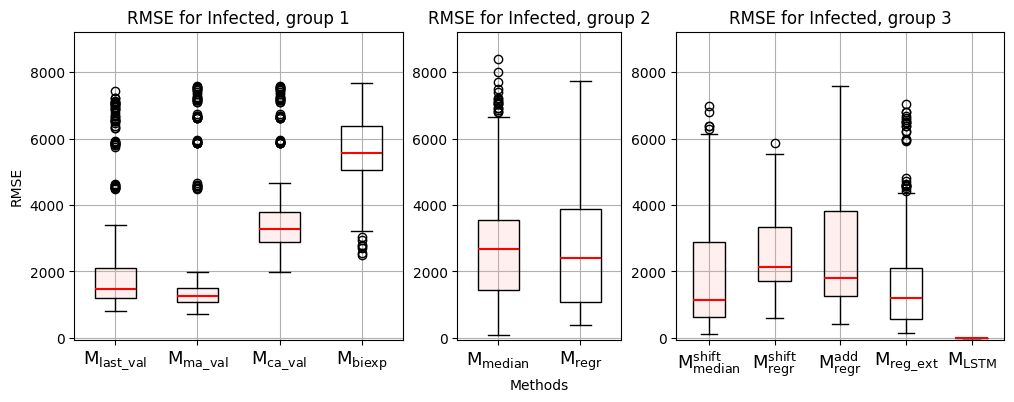

In [8]:
# 
# 1142 median_beta_shifted_forecast    
# 1194 regression_day_SEIR_previous_I  
# 1257 rolling_mean_last_value 
create_boxplots(seed_dirs='initial_data/new_sw_100000/', 
                type_start_day='roll_var_npeople', n_seeds=301,
               is_filename=True, suf='_v2')

## peaks

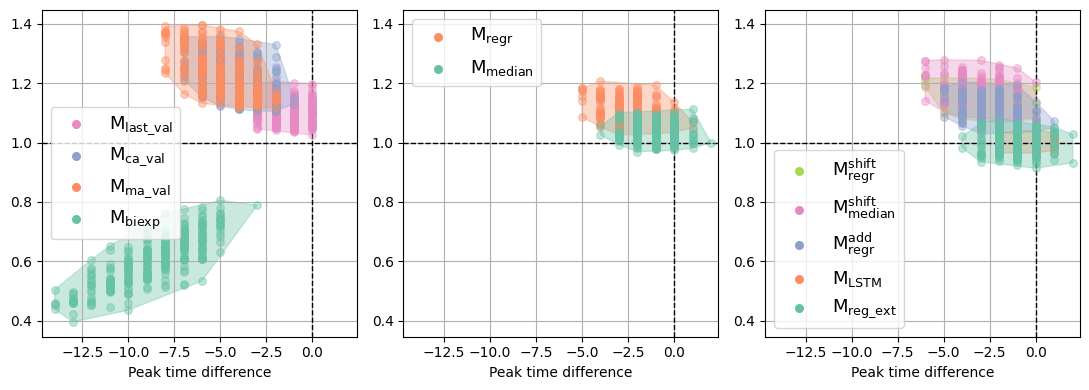

In [59]:
create_peak_plot(folder = 'new_ba_10000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

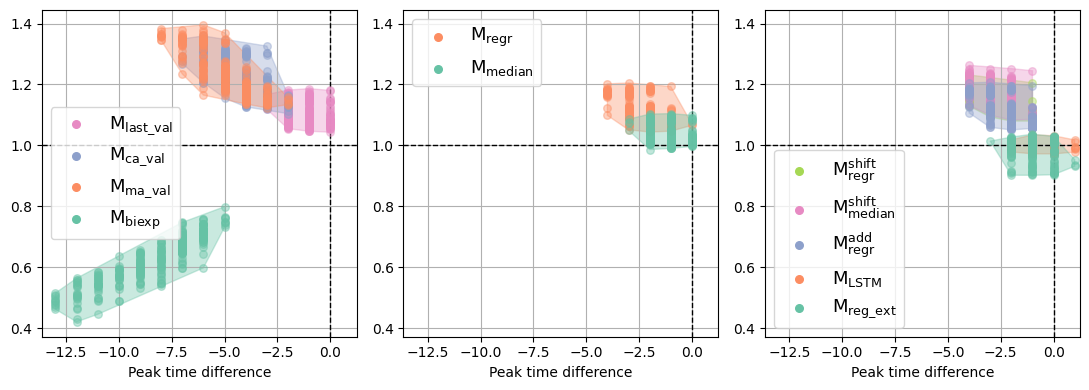

In [32]:
create_peak_plot(folder = 'new_ba_50000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

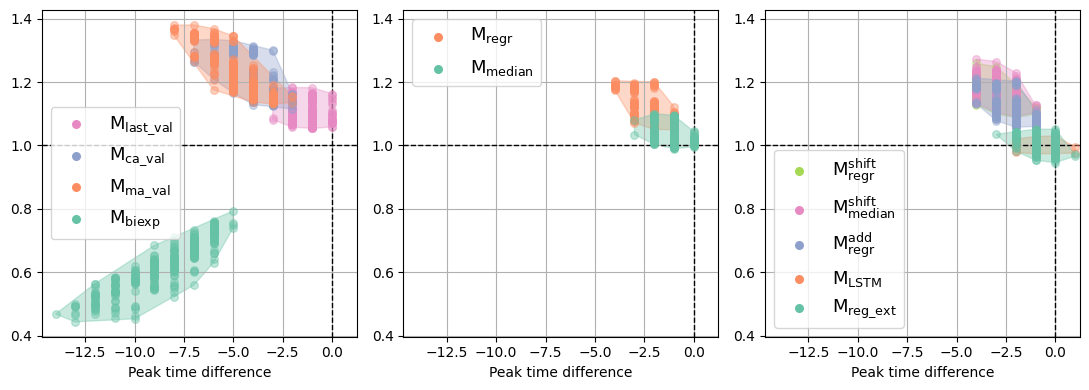

In [9]:
create_peak_plot(folder = 'new_ba_100000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

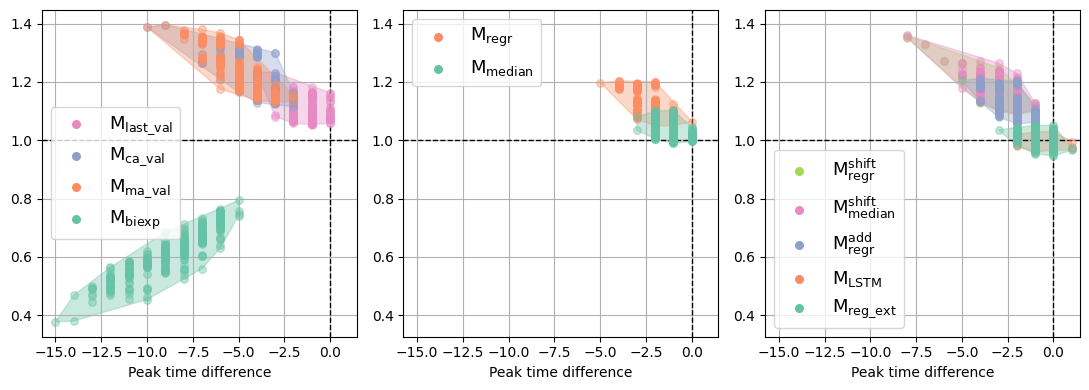

In [11]:
create_peak_plot(folder = 'new_ba_100000', switch = 'roll_var_npeople',
                with_outliers=True, same_lims=True)

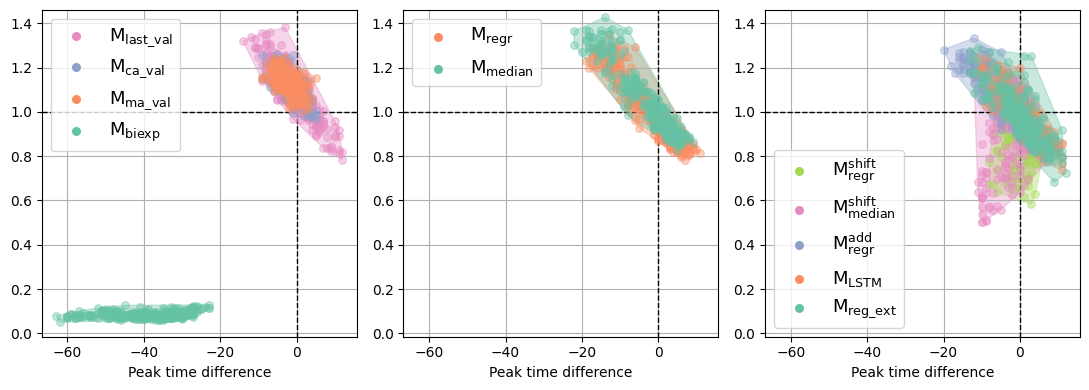

In [34]:
create_peak_plot(folder = 'new_r_10000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

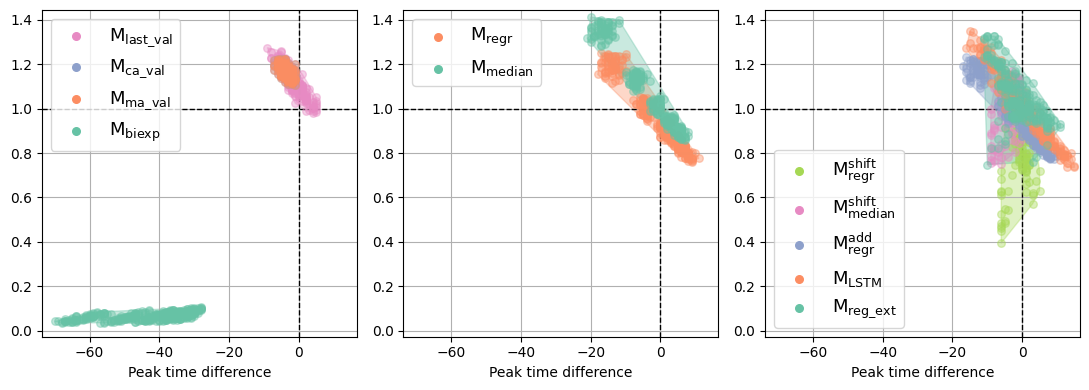

In [35]:
create_peak_plot(folder = 'new_r_50000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

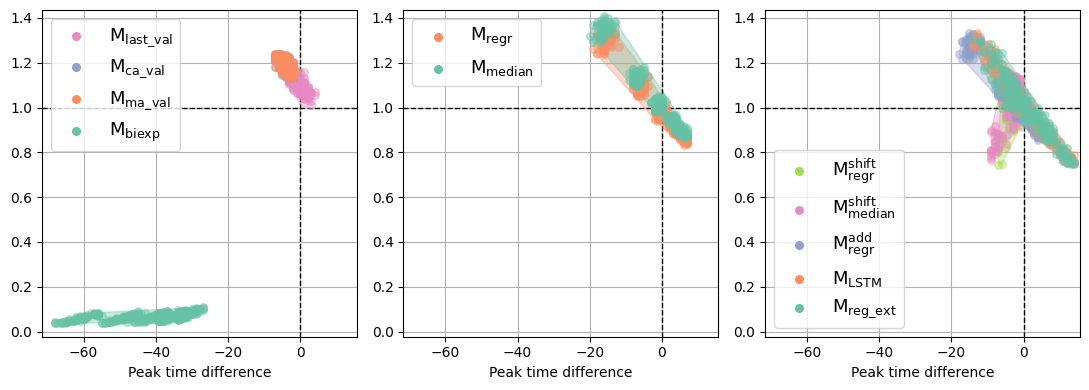

In [36]:
create_peak_plot(folder = 'new_r_100000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

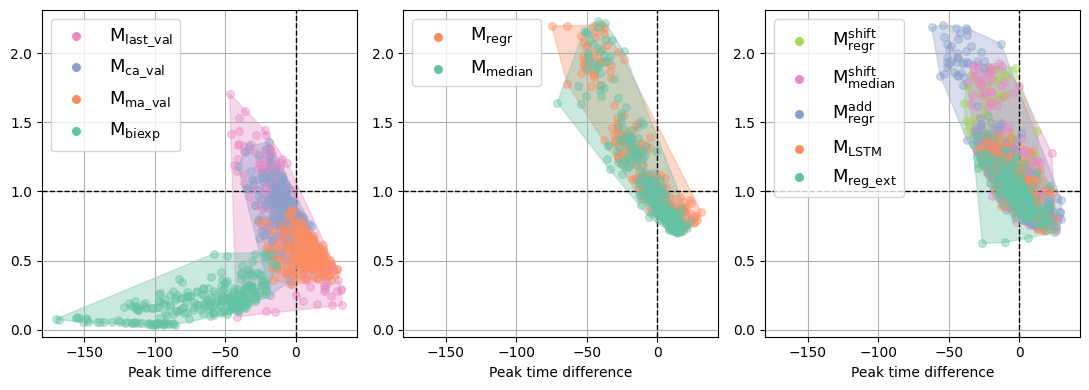

In [37]:
create_peak_plot(folder = 'new_sw_10000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

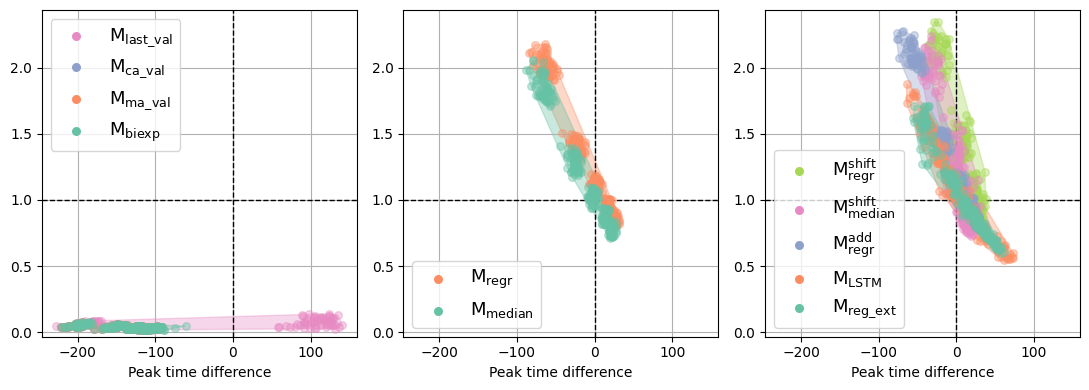

In [38]:
create_peak_plot(folder = 'new_sw_50000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

---- No data for lstm_day_E_previous_I ----


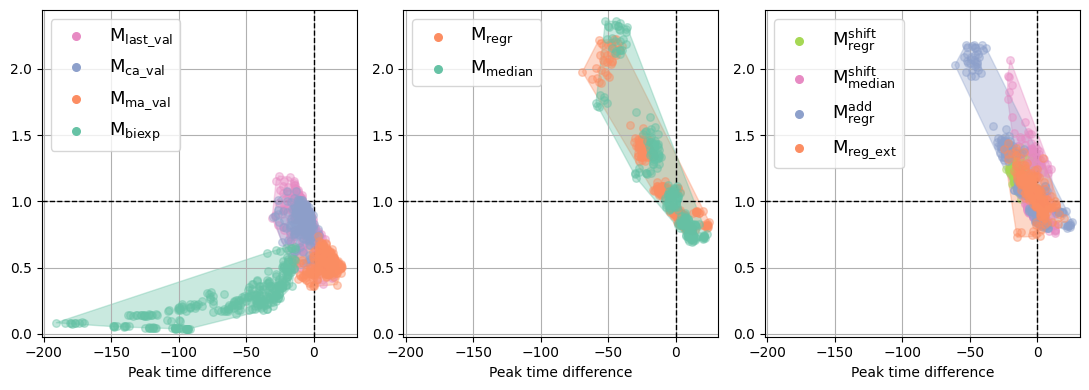

In [63]:
create_peak_plot(folder = 'new_sw_50000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True, suf='_v2')

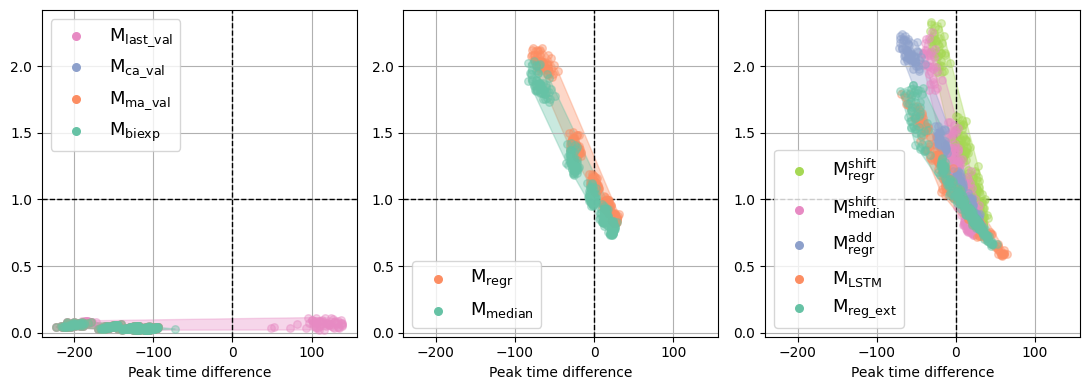

In [39]:
create_peak_plot(folder = 'new_sw_100000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True)

---- No data for lstm_day_E_previous_I ----


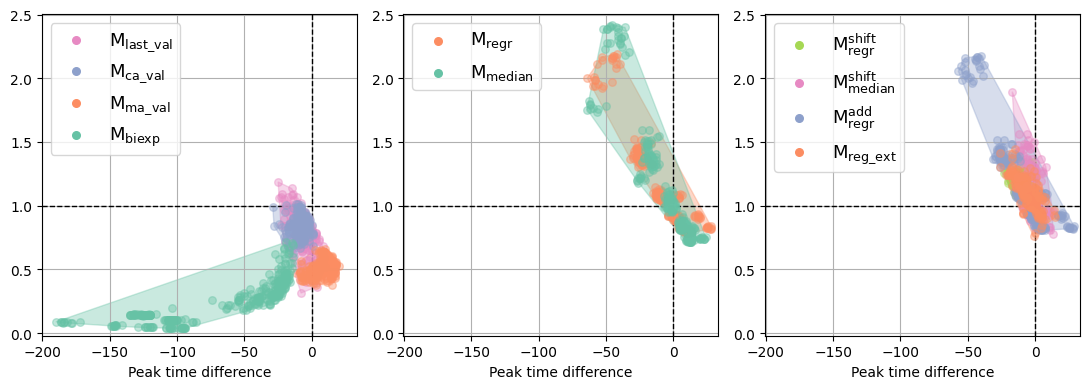

In [64]:
create_peak_plot(folder = 'new_sw_100000', switch = 'roll_var_npeople',
                with_outliers=False, same_lims=True, suf='_v2')